#### Extra Credit

Extra Credit portion is at the bottom of the notebook

# Image Generation
In this notebook we will continue our exploration of image gradients using the deep model that was pretrained on TinyImageNet. We will explore various ways of using these image gradients to generate images. We will implement class visualizations, feature inversion, and DeepDream.

In [1]:
# As usual, a bit of setup

import time, os, json
import numpy as np
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt

from cs294_129.classifiers.pretrained_cnn import PretrainedCNN
from cs294_129.data_utils import load_tiny_imagenet
from cs294_129.image_utils import blur_image, deprocess_image, preprocess_image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# TinyImageNet and pretrained model
As in the previous notebook, load the TinyImageNet dataset and the pretrained model.

In [4]:
data = load_tiny_imagenet('cs294_129/datasets/tiny-imagenet-100-A', subtract_mean=True)
model = PretrainedCNN(h5_file='cs294_129/datasets/pretrained_model.h5')

loading training data for synset 20 / 100
loading training data for synset 40 / 100
loading training data for synset 60 / 100
loading training data for synset 80 / 100
loading training data for synset 100 / 100


# DeepDream
In the summer of 2015, Google released a [blog post](http://googleresearch.blogspot.com/2015/06/inceptionism-going-deeper-into-neural.html) describing a new method of generating images from neural networks, and they later [released code](https://github.com/google/deepdream) to generate these images.

The idea is very simple. We pick some layer from the network, pass the starting image through the network to extract features at the chosen layer, set the gradient at that layer equal to the activations themselves, and then backpropagate to the image. This has the effect of modifying the image to amplify the activations at the chosen layer of the network.

For DeepDream we usually extract features from one of the convolutional layers, allowing us to generate images of any resolution.

We can implement this idea using our pretrained network. The results probably won't look as good as Google's since their network is much bigger, but we should still be able to generate some interesting images.

In [2]:
def deepdream(X, layer, model, **kwargs):
  """
  Generate a DeepDream image.
  
  Inputs:
  - X: Starting image, of shape (1, 3, H, W)
  - layer: Index of layer at which to dream
  - model: A PretrainedCNN object
  
  Keyword arguments:
  - learning_rate: How much to update the image at each iteration
  - max_jitter: Maximum number of pixels for jitter regularization
  - num_iterations: How many iterations to run for
  - show_every: How often to show the generated image
  """
  
  X = X.copy()
  
  learning_rate = kwargs.pop('learning_rate', 5.0)
  max_jitter = kwargs.pop('max_jitter', 16)
  num_iterations = kwargs.pop('num_iterations', 100)
  show_every = kwargs.pop('show_every', 25)
  
  for t in xrange(num_iterations):
    # As a regularizer, add random jitter to the image
    ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
    X = np.roll(np.roll(X, ox, -1), oy, -2)

    dX = None
    ############################################################################
    # TODO: Compute the image gradient dX using the DeepDream method. You'll   #
    # need to use the forward and backward methods of the model object to      #
    # extract activations and set gradients for the chosen layer. After        #
    # computing the image gradient dX, you should use the learning rate to     #
    # update the image X.                                                      #
    ############################################################################
    feats, cache = model.forward(X, end=layer, mode='test')
    dX, _ = model.backward(feats, cache)
    X += learning_rate * dX
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    
    # Undo the jitter
    X = np.roll(np.roll(X, -ox, -1), -oy, -2)
    
    # As a regularizer, clip the image
    mean_pixel = data['mean_image'].mean(axis=(1, 2), keepdims=True)
    X = np.clip(X, -mean_pixel, 255.0 - mean_pixel)
    
    # Periodically show the image
    if t == 0 or (t + 1) % show_every == 0:
      img = deprocess_image(X, data['mean_image'], mean='pixel')
      plt.imshow(img)
      plt.title('t = %d' % (t + 1))
      plt.gcf().set_size_inches(8, 8)
      plt.axis('off')
      plt.show()
  return X

### Extra credit

For the extra credit, I considered the use of DeepDream using mulitple image sources. 
In this section, I first explored simply concatenating images (such as the bear_0038.jpg) with the kitten img

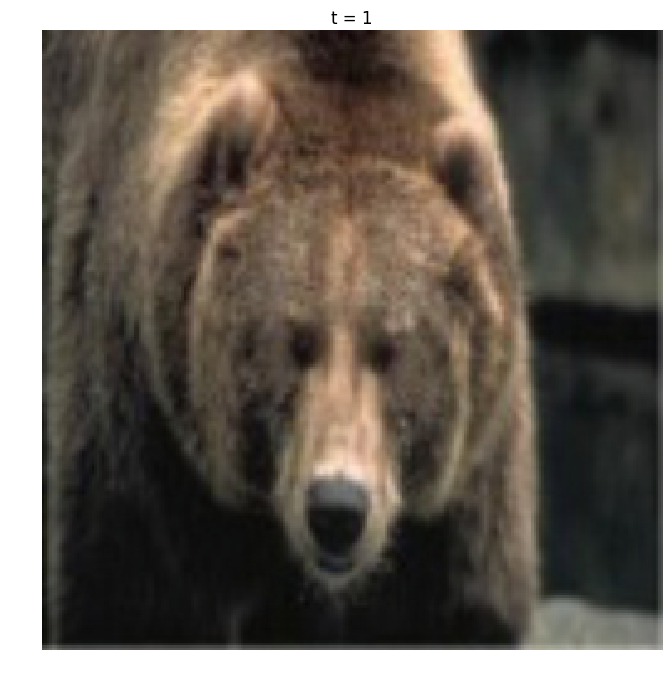

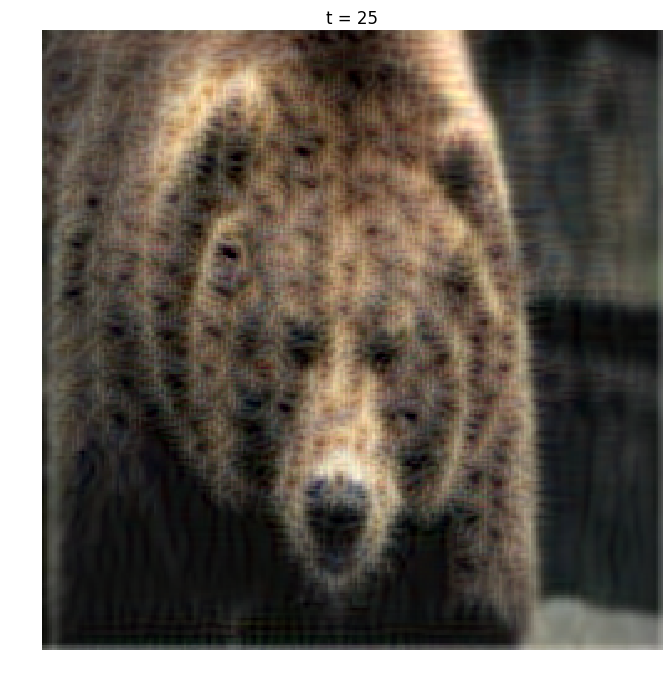

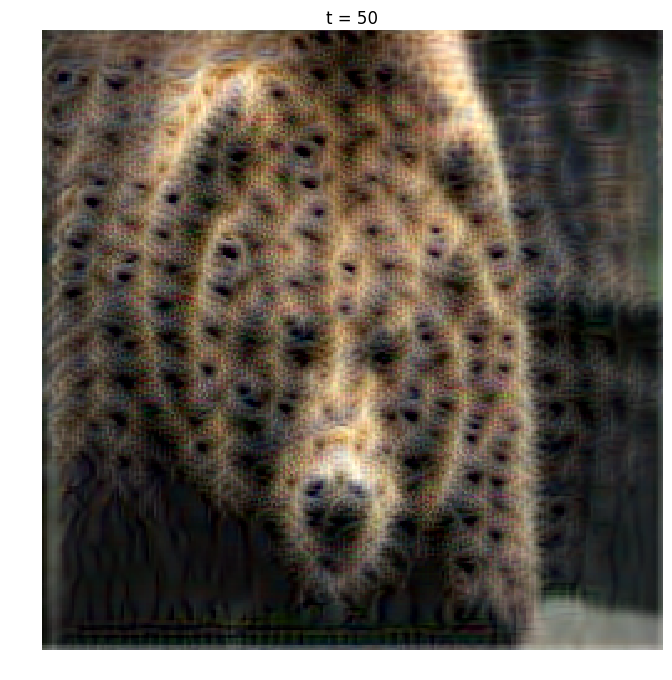

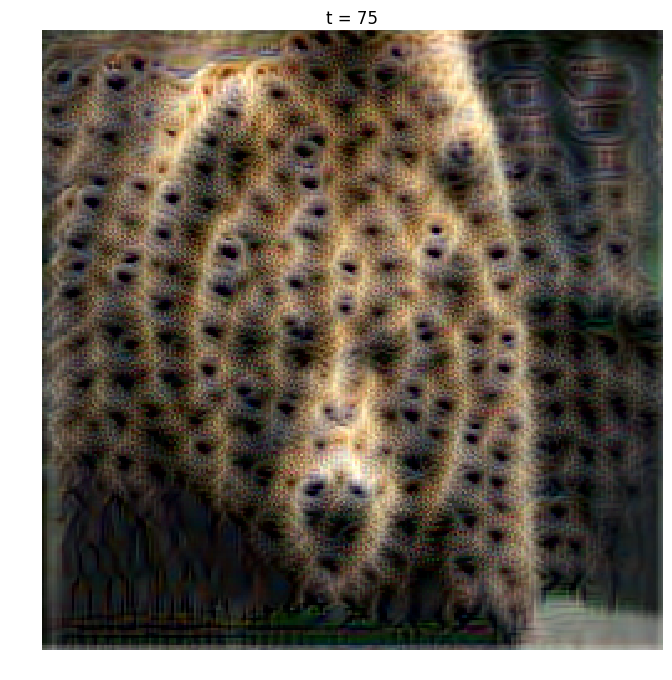

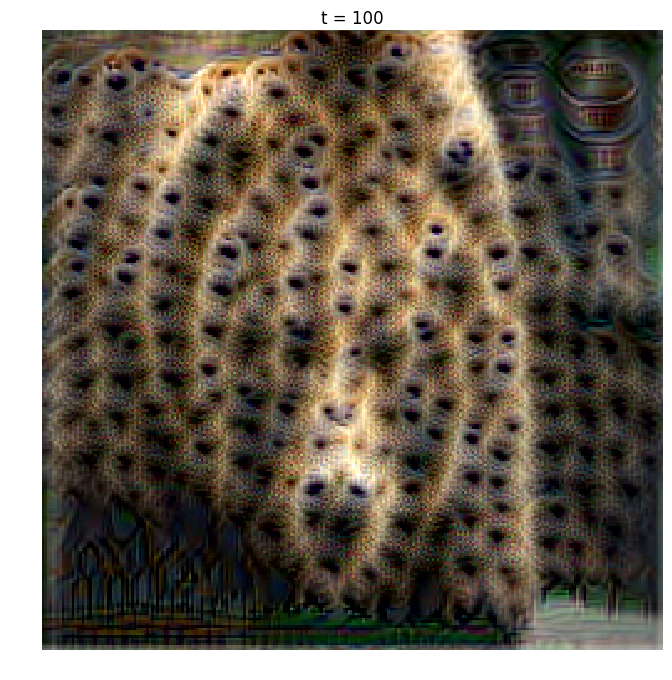

In [5]:
def read_image(filename, max_size):
  """
  Read an image from disk and resize it so its larger side is max_size
  """
  img = imread(filename)
  H, W, _ = img.shape
  if H >= W:
    img = imresize(img, (max_size, int(W * float(max_size) / H)))
  elif H < W:
    img = imresize(img, (int(H * float(max_size) / W), max_size))
  return img

filename = 'bear_0038.jpg'
max_size = 250
img = read_image(filename, max_size)
plt.imshow(img)
plt.axis('off')

# Preprocess the image by converting to float, transposing,
# and performing mean subtraction.
img_pre = preprocess_image(img, data['mean_image'], mean='pixel')

out = deepdream(img_pre, 7, model, learning_rate=2000)

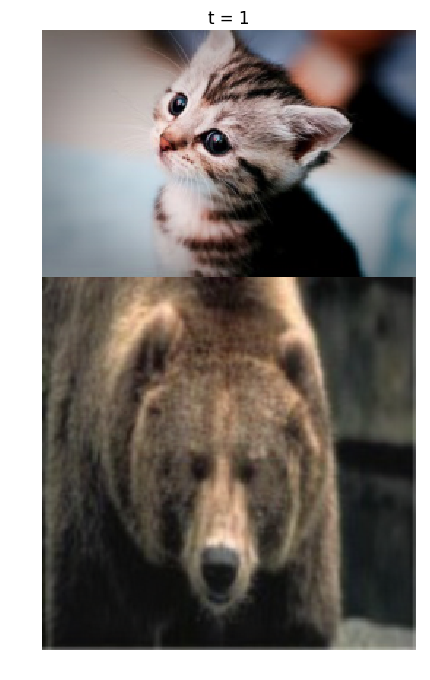

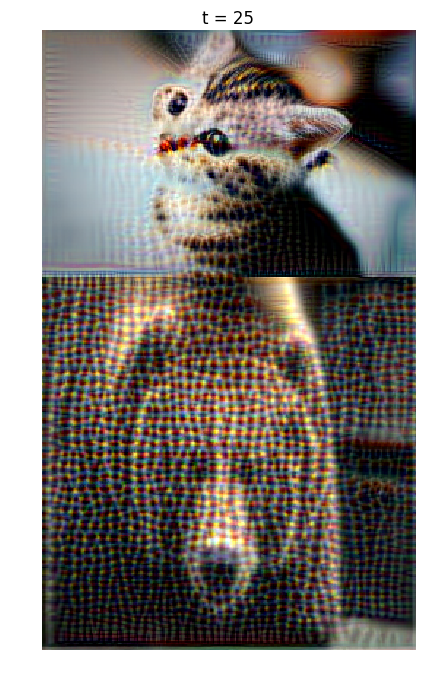

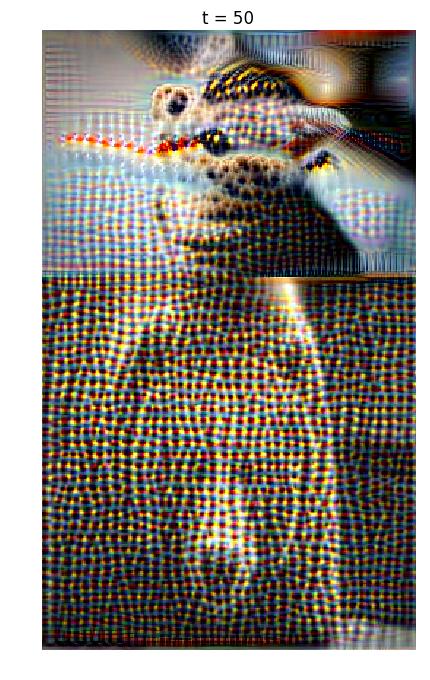

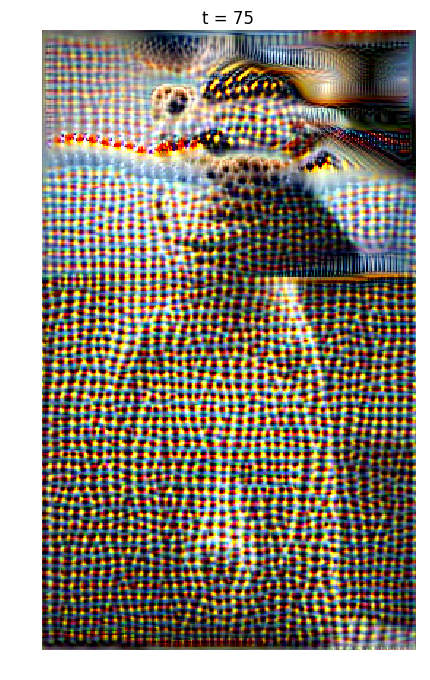

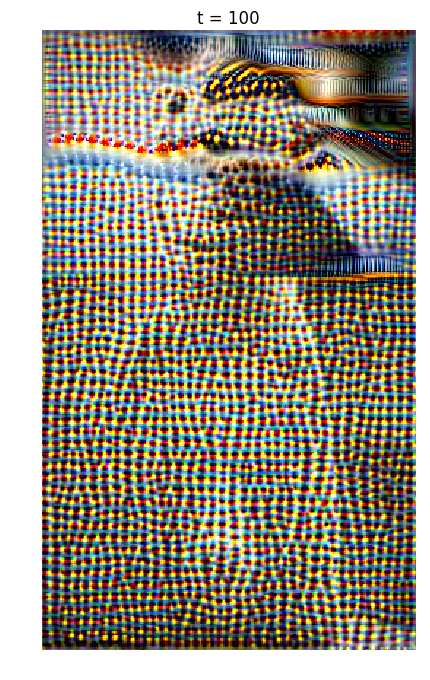

In [34]:
def read_images(filename, max_size):
  """
  Read an image from disk and resize it so its larger side is max_size
  """
  img = imread(filename)
  H, W, _ = img.shape
  if H >= W:
    img = imresize(img, (max_size, int(W * float(max_size) / H)))
  elif H < W:
    img = imresize(img, (int(H * float(max_size) / W), max_size))
  return img

def read_images2(img1, img2, max_size):
  """
  Read an image from disk and resize it so its larger side is max_size
  """
  img = imread(filename)
  H, W, _ = img.shape
  if H >= W:
    img = imresize(img, (max_size, int(W * float(max_size) / H)))
  elif H < W:
    img = imresize(img, (int(H * float(max_size) / W), max_size))
  return img

filename1 = 'kitten.jpg'
filename2 = 'bear_0038.jpg'
max_size = 256
img1 = read_images(filename1, max_size)
img2 = read_images(filename2, max_size)
img = np.concatenate((img1, img2), axis = 0)
#print(img1.shape, img2.shape, img.shape)
plt.imshow(img)
plt.axis('off')

# Preprocess the image by converting to float, transposing,
# and performing mean subtraction.
img_pre = preprocess_image(img, data['mean_image'], mean='pixel')

out = deepdream(img_pre, 5, model, learning_rate=2000)

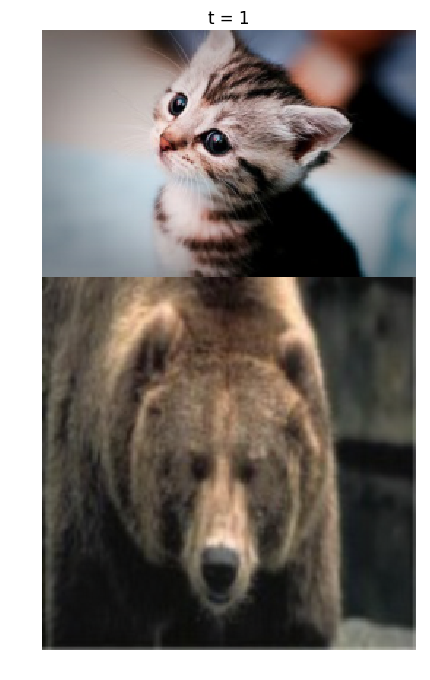

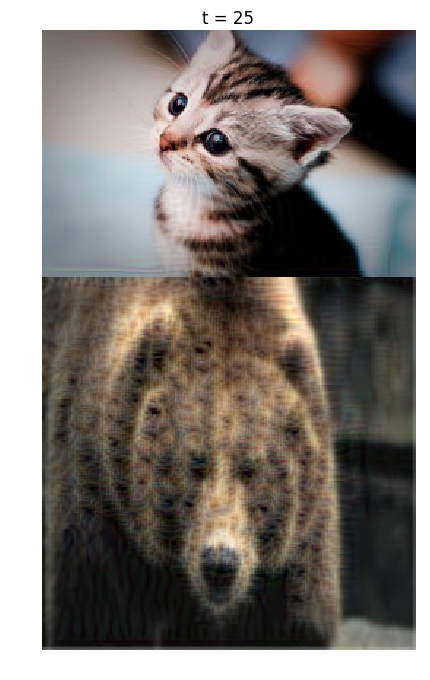

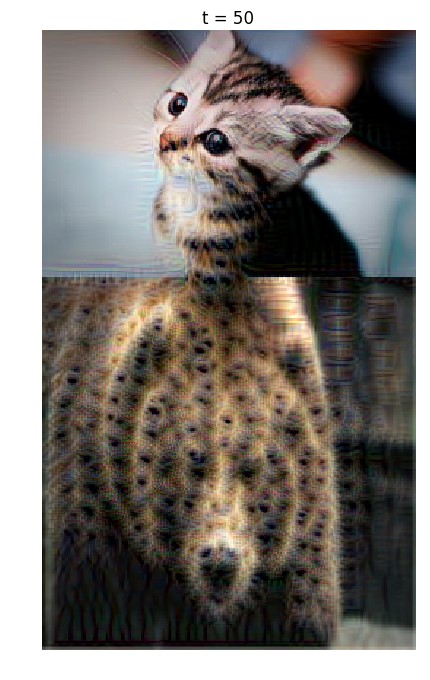

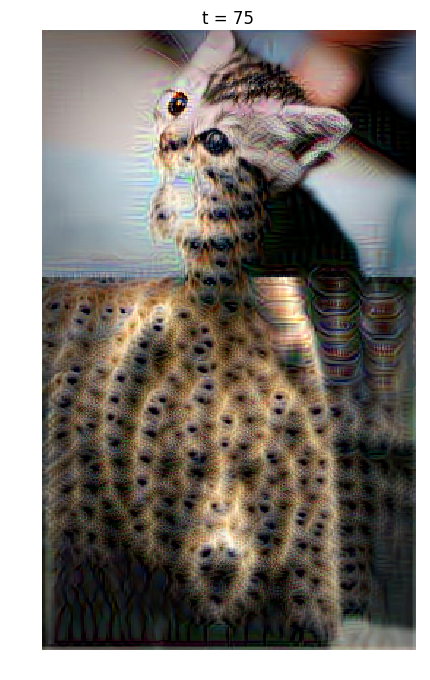

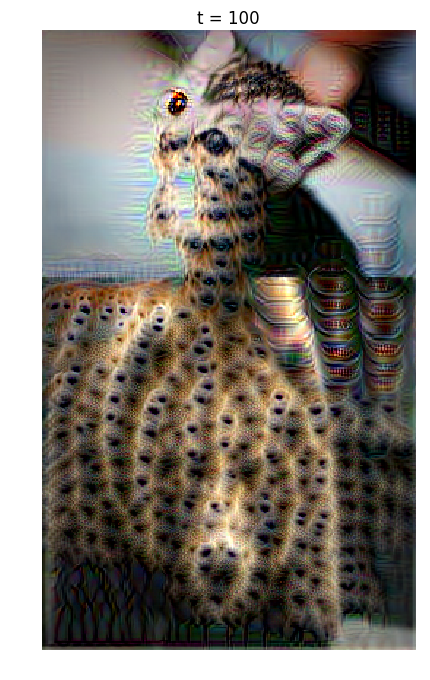

In [28]:
def read_images(filename, max_size):
  """
  Read an image from disk and resize it so its larger side is max_size
  """
  img = imread(filename)
  H, W, _ = img.shape
  if H >= W:
    img = imresize(img, (max_size, int(W * float(max_size) / H)))
  elif H < W:
    img = imresize(img, (int(H * float(max_size) / W), max_size))
  return img

def read_images2(img1, img2, max_size):
  """
  Read an image from disk and resize it so its larger side is max_size
  """
  img = imread(filename)
  H, W, _ = img.shape
  if H >= W:
    img = imresize(img, (max_size, int(W * float(max_size) / H)))
  elif H < W:
    img = imresize(img, (int(H * float(max_size) / W), max_size))
  return img

filename1 = 'kitten.jpg'
filename2 = 'bear_0038.jpg'
max_size = 256
img1 = read_images(filename1, max_size)
img2 = read_images(filename2, max_size)
img = np.concatenate((img1, img2), axis = 0)
#print(img1.shape, img2.shape, img.shape)
plt.imshow(img)
plt.axis('off')

# Preprocess the image by converting to float, transposing,
# and performing mean subtraction.
img_pre = preprocess_image(img, data['mean_image'], mean='pixel')

out = deepdream(img_pre, 7, model, learning_rate=2000)

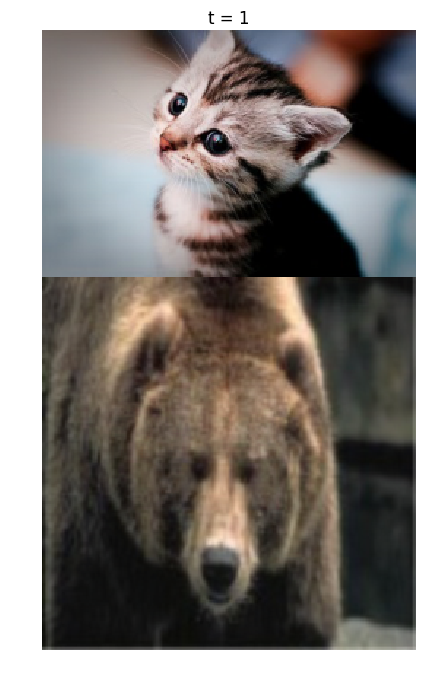

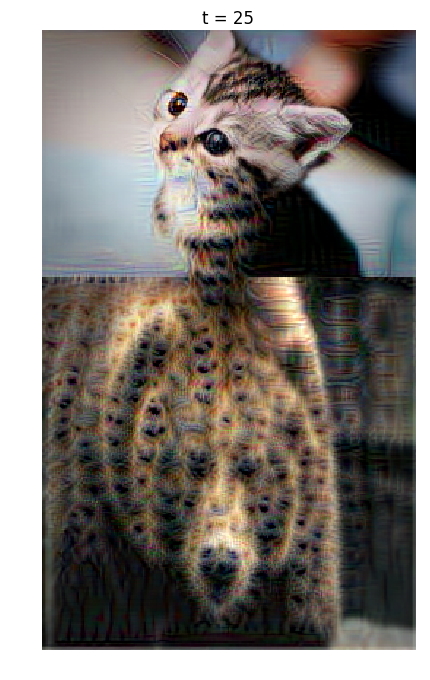

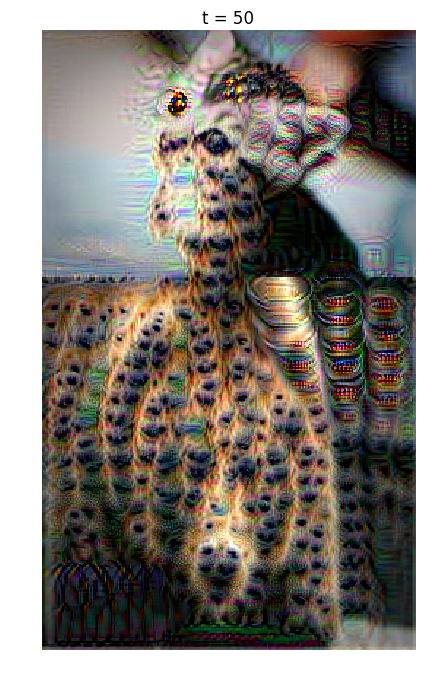

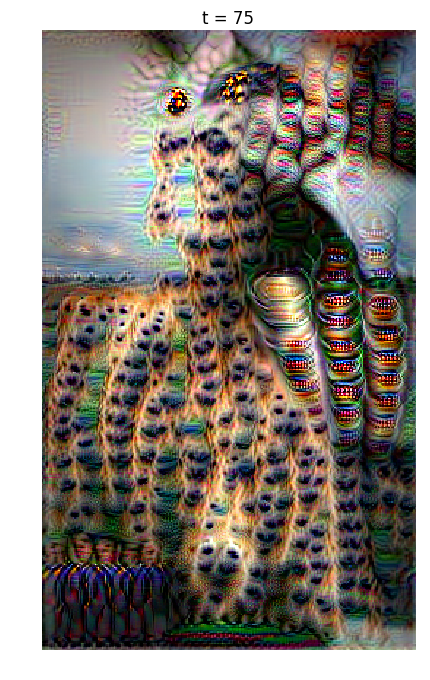

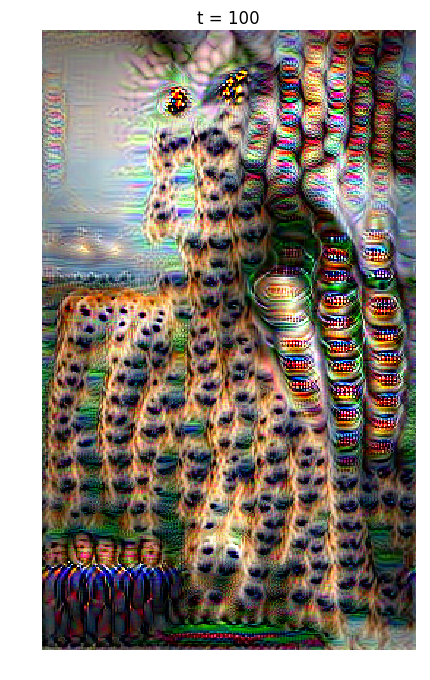

In [29]:
def read_images(filename, max_size):
  """
  Read an image from disk and resize it so its larger side is max_size
  """
  img = imread(filename)
  H, W, _ = img.shape
  if H >= W:
    img = imresize(img, (max_size, int(W * float(max_size) / H)))
  elif H < W:
    img = imresize(img, (int(H * float(max_size) / W), max_size))
  return img

def read_images2(img1, img2, max_size):
  """
  Read an image from disk and resize it so its larger side is max_size
  """
  img = imread(filename)
  H, W, _ = img.shape
  if H >= W:
    img = imresize(img, (max_size, int(W * float(max_size) / H)))
  elif H < W:
    img = imresize(img, (int(H * float(max_size) / W), max_size))
  return img

filename1 = 'kitten.jpg'
filename2 = 'bear_0038.jpg'
max_size = 256
img1 = read_images(filename1, max_size)
img2 = read_images(filename2, max_size)
img = np.concatenate((img1, img2), axis = 0)
#print(img1.shape, img2.shape, img.shape)
plt.imshow(img)
plt.axis('off')

# Preprocess the image by converting to float, transposing,
# and performing mean subtraction.
img_pre = preprocess_image(img, data['mean_image'], mean='pixel')

out = deepdream(img_pre, 7, model, learning_rate=5000)

I then explored the combining different channels of multiple images. In the following example, I used the bear image's blue channel in place of the kitten's blue channel and was able to use DeepDream to create a cartoonish tiger looking like character!

((170, 256, 3), (256, 256, 3), (170, 256, 3))


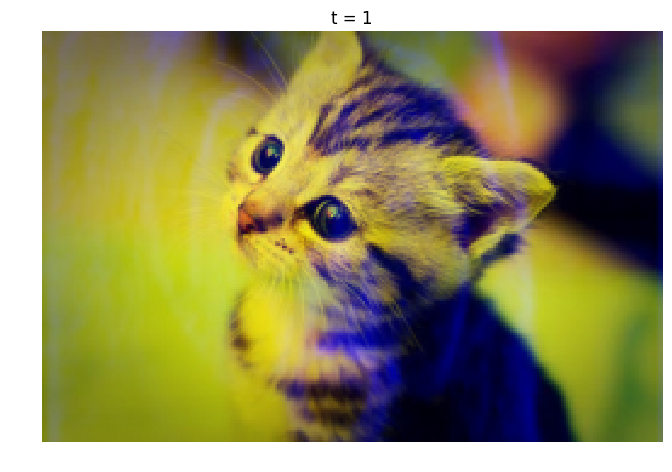

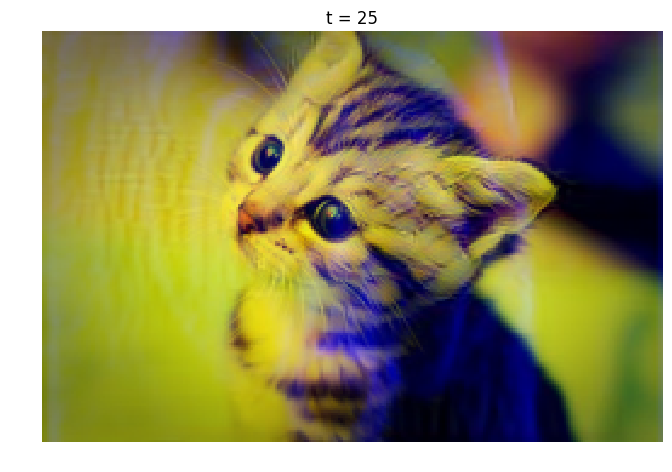

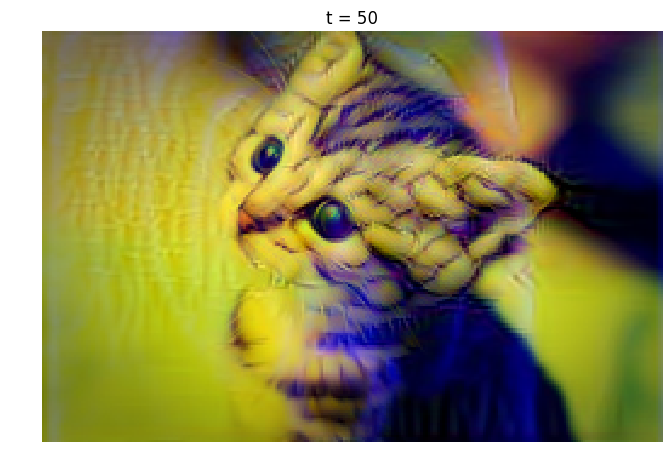

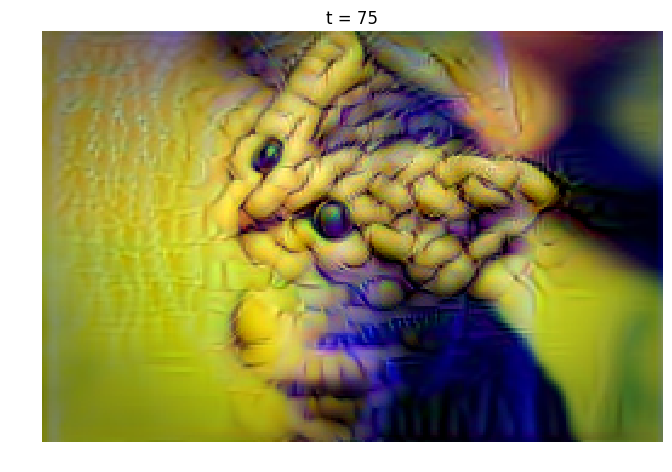

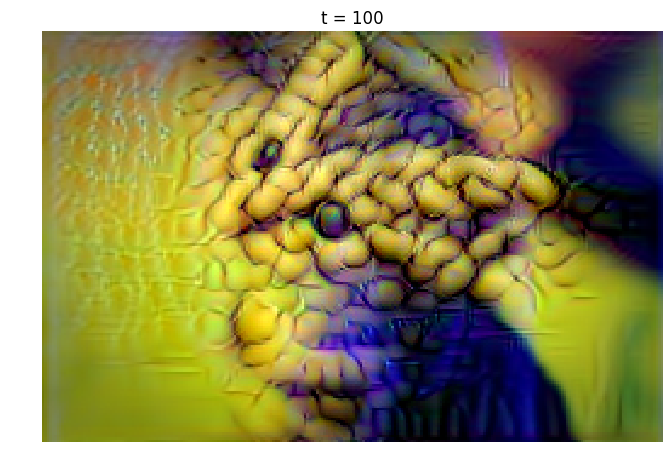

In [64]:
def read_images(filename, max_size):
  """
  Read an image from disk and resize it so its larger side is max_size
  """
  img = imread(filename)
  H, W, _ = img.shape
  if H >= W:
    img = imresize(img, (max_size, int(W * float(max_size) / H)))
  elif H < W:
    img = imresize(img, (int(H * float(max_size) / W), max_size))
  return img

def read_images2(img1, img2, max_size):
  """
  Read an image from disk and resize it so its larger side is max_size
  """
  img = imread(filename)
  H, W, _ = img.shape
  if H >= W:
    img = imresize(img, (max_size, int(W * float(max_size) / H)))
  elif H < W:
    img = imresize(img, (int(H * float(max_size) / W), max_size))
  return img

filename1 = 'kitten.jpg'
filename2 = 'bear_0038.jpg'
max_size = 256
img1 = read_images(filename1, max_size)
img2 = read_images(filename2, max_size)
img3 = img1[:, :, 0:2]
img4 = img2[50:220, :, 2].reshape(170, 256, 1)
img = np.concatenate((img3, img4), axis = 2)
#img = np.concatenate((img1[:, :, 0:1], img2[50:220,:,2].reshape(170, 256, 1)), axis = 2)
print(img1.shape, img2.shape, img.shape)
plt.imshow(img)
plt.axis('off')

# Preprocess the image by converting to float, transposing,
# and performing mean subtraction.
img_pre = preprocess_image(img, data['mean_image'], mean='pixel')

out = deepdream(img_pre, 7, model, learning_rate=2000)

((170, 256, 3), (256, 256, 3), (170, 256, 3))


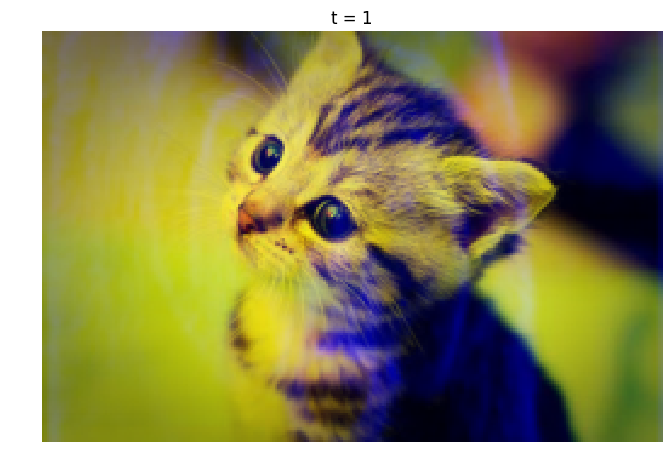

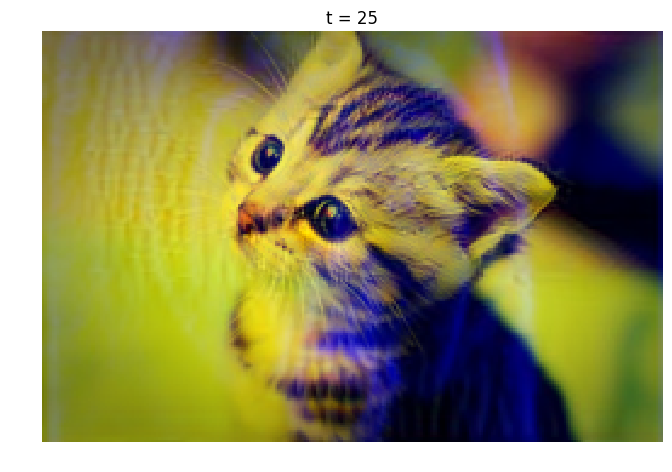

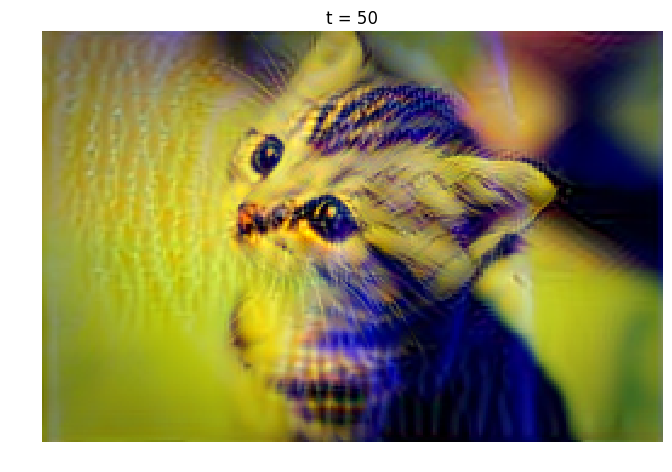

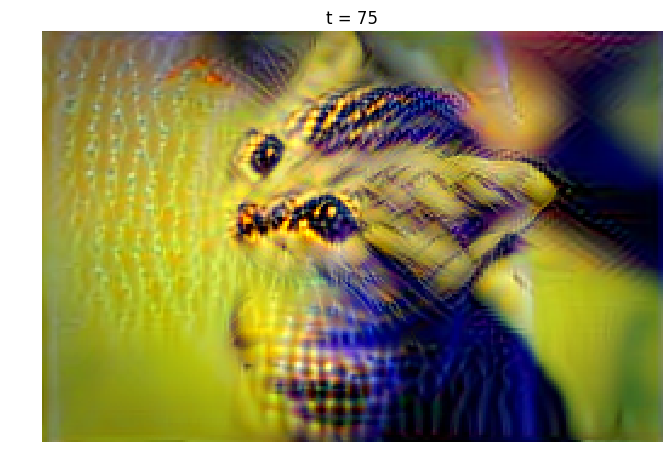

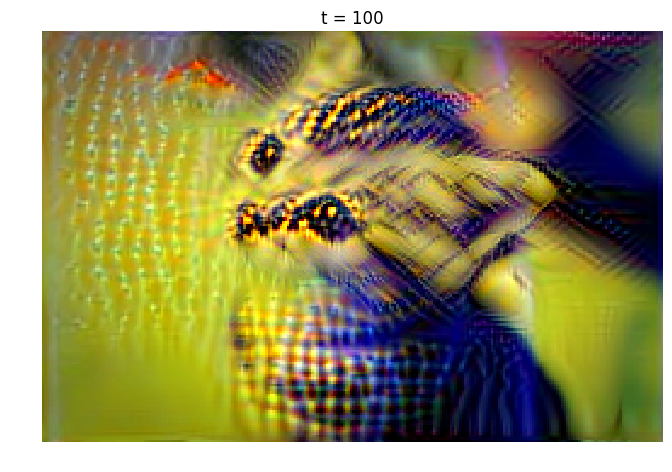

In [65]:
def read_images(filename, max_size):
  """
  Read an image from disk and resize it so its larger side is max_size
  """
  img = imread(filename)
  H, W, _ = img.shape
  if H >= W:
    img = imresize(img, (max_size, int(W * float(max_size) / H)))
  elif H < W:
    img = imresize(img, (int(H * float(max_size) / W), max_size))
  return img

def read_images2(img1, img2, max_size):
  """
  Read an image from disk and resize it so its larger side is max_size
  """
  img = imread(filename)
  H, W, _ = img.shape
  if H >= W:
    img = imresize(img, (max_size, int(W * float(max_size) / H)))
  elif H < W:
    img = imresize(img, (int(H * float(max_size) / W), max_size))
  return img

filename1 = 'kitten.jpg'
filename2 = 'bear_0038.jpg'
max_size = 256
img1 = read_images(filename1, max_size)
img2 = read_images(filename2, max_size)
img3 = img1[:, :, 0:2]
img4 = img2[50:220, :, 2].reshape(170, 256, 1)
img = np.concatenate((img3, img4), axis = 2)
#img = np.concatenate((img1[:, :, 0:1], img2[50:220,:,2].reshape(170, 256, 1)), axis = 2)
print(img1.shape, img2.shape, img.shape)
plt.imshow(img)
plt.axis('off')

# Preprocess the image by converting to float, transposing,
# and performing mean subtraction.
img_pre = preprocess_image(img, data['mean_image'], mean='pixel')

out = deepdream(img_pre, 6, model, learning_rate=2000)